# spaTrack's multiple origins processing

This notebook uses the iCAF data to show how spaTrack handles when data has multiple origins.

In [1]:
import sti
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

Import the iCAF data. 

In [2]:
adata=sc.read('./data/iCAF/iCAF_exp_count.1.tsv',cache=True)
adata=adata.T
cell_id=pd.read_table('./data/iCAF/cell_id.tsv',header=None)
gene_id=pd.read_table('./data/iCAF/gene_id.tsv',header=None)
adata.obs.index = np.array(cell_id[0])
adata.var.index = np.array(gene_id[0])
coor=pd.read_table('./data/iCAF/cell_coor.tsv',header=None)
anno=pd.read_table('./data/iCAF/cell_annot.tsv',header=None)
adata.obs['cluster'] = np.array(anno.loc[0])
adata.obsm['X_spatial'] = np.array(coor)

Do the basic preprocessing and then visualize based on spatial information.

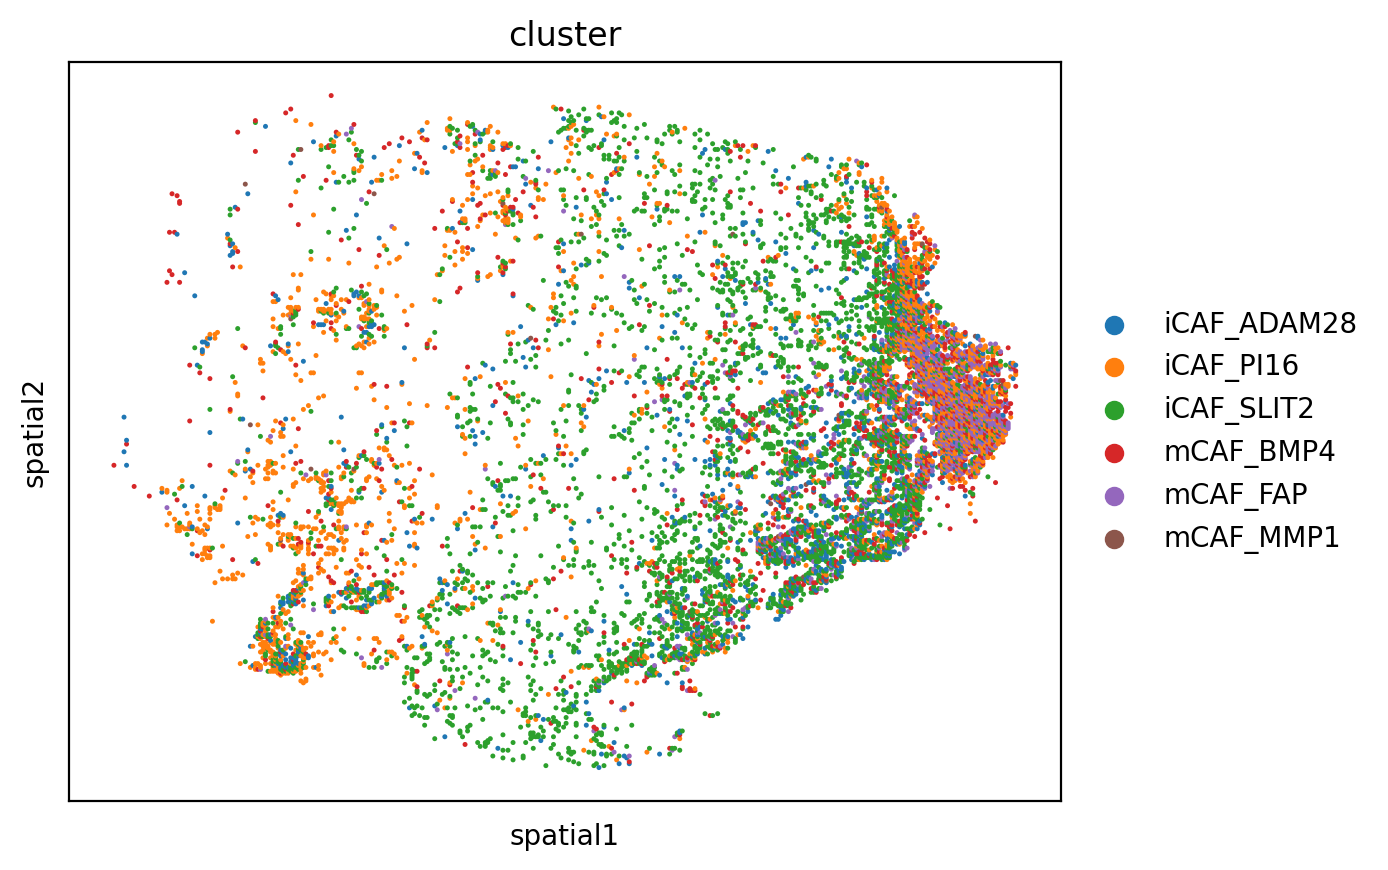

In [3]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

sc.pl.embedding(adata,basis='spatial',color='cluster')

## Compute the trajectory velocity

Now, we start to calculate the trajectory velocity.

First, the cell transition probability matrix is calculated through the optiml transport theory. A 'N x N'(N is the cell number) matrix will be generated. 

There are two modes of 'single-cell' and 'spatial'. In spatial mode, cell spatial position information will be additionally utilized.

In [4]:
adata.obsp['trans']=sti.vlc.get_ot_matrix(adata,data_type='spatial')

X_pca is not in adata.obsm, automatically do PCA first.


Now we will decide the starting cells.

According to prior knowledge, the starting cluster of iCAF data is the iCAF_PI16 cluster. However, in the visualization results, we can see that this type of cells are distributed in different positions. If you simply select the entire cluster, the result will be inaccurate. Here, the kmeans method is used to find the aggregation points of the cells in the cluster and the neighbor cells are taken as the starting cells.

kmean cluster centers:
[ 7960.73384447 12159.20043812]
[18347.76536313 14761.29289705]


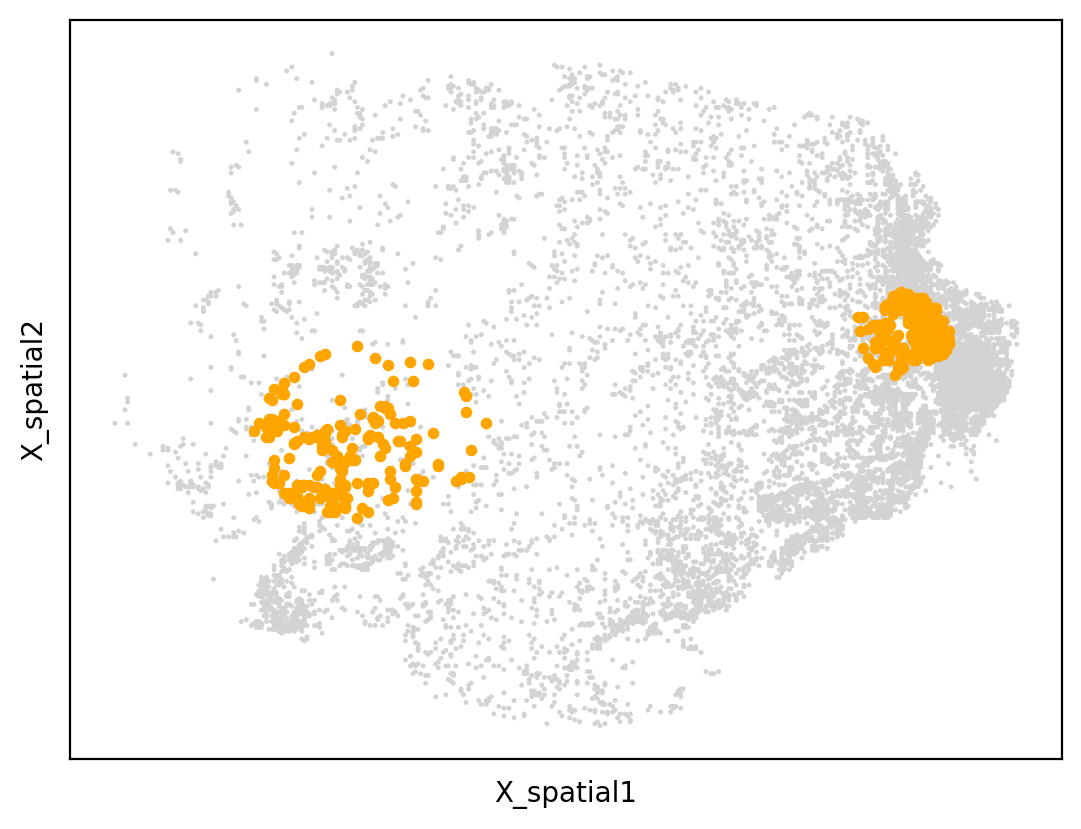

In [5]:
start_cells=sti.vlc.set_start_cells(adata,select_way='partition',cell_type='iCAF_PI16',n_neigh=200,n_clusters=2)

start_points = sc.pl.embedding(adata, basis='X_spatial',show=False)
points = adata.obsm['X_spatial'][start_cells]
start_points.scatter(points[:, 0], points[:, 1], s=10, color='orange')

Infer the cell pseudotime based on the OT matrix and start cells. 

In [6]:
adata.obs['ptime']=sti.vlc.get_ptime(adata,start_cells)

Calculate the vector field velocity. 

An important factor for cell velocity is cell neighbor selection. Neighbors can be selected in terms of cell Coordinates or gene expression, corresponding to 'n_neigh_pos' and 'n_neigh_gene' respectively. Coordinate neighbors are determined by KNN and gene neighbors are determined by Euclidean distance between cell expression. Then the intersection of coordinates neighbors and embedding matrix neighbors were used as final neighbors of each spot.

Then use the direction of the cell pointing to the neighbor as the speed direction (pseudo-timing determines whether the direction is reversed), the transition probability of the cell and its neighbors as the speed, and take the average as the final speed.

Finally, cell velocities are converted to grid velocities using the distance of the cells from the grid as weights. The visualization of vector field was adapted from sctour (Li, 2022).

In [7]:
adata.uns['E_grid'],adata.uns['V_grid']=sti.vlc.get_velocity(adata,basis='spatial',n_neigh_pos=100,n_neigh_gene=0)

Display the spatial information of cells, starting cells, the cell pseudotime and the inferred cell trajectory respectively.

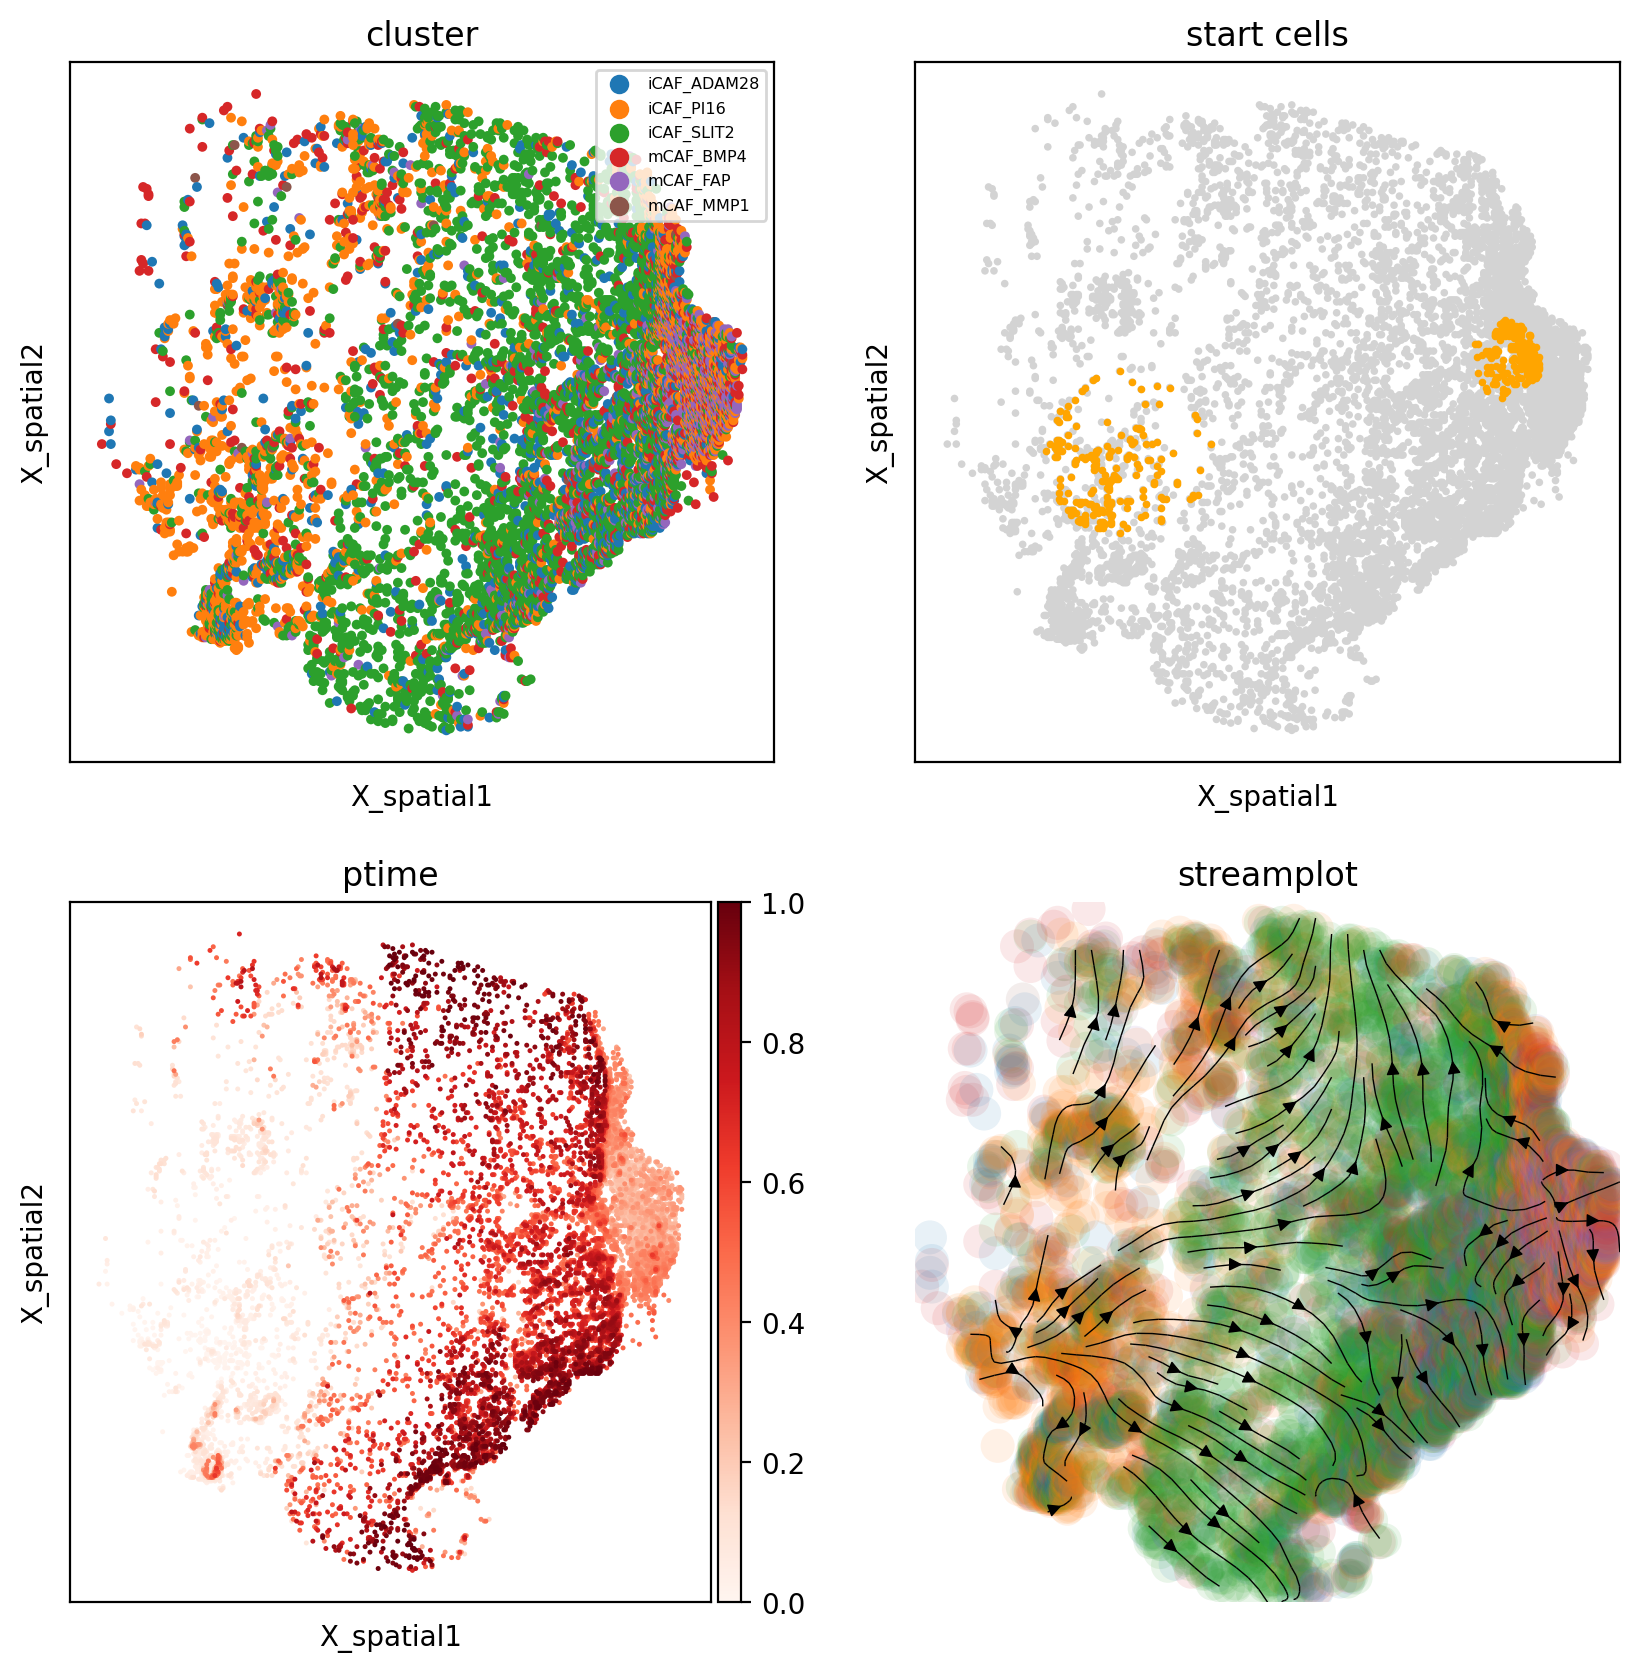

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.embedding(adata, basis='X_spatial', color='cluster', size=20, ax=axs[0][0], show=False, s=50)
axs[0][0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),fontsize='xx-small')

start_points = sc.pl.embedding(adata, basis='X_spatial',ax=axs[0][1], show=False, title='start cells',s=30)
points = adata.obsm['X_spatial'][start_cells]
start_points.scatter(points[:, 0], points[:, 1], s=3, color='orange')

sc.pl.embedding(adata, basis='X_spatial', color='ptime', show=False, ax=axs[1][0], color_map='Reds', title='ptime')

vf_velocity = sc.pl.embedding(adata, basis='X_spatial', show=False, ax=axs[1][1],color='cluster', legend_loc=None, frameon=False, title='streamplot', alpha=0.1, size=600)
vf_velocity.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], color='black', linewidth=0.5,density=1.5)